In [7]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, classification_report, plot_confusion_matrix

def minMaxScaleContinuous(continuousList):
    return pd.DataFrame(MinMaxScaler().fit_transform(data[continuousList])
                             ,columns=list(data[continuousList].columns)
                             ,index = data[continuousList].index)

def createDiscreteDummies(discreteList):
    return pd.get_dummies(data[discreteList], dummy_na = True, prefix_sep = "::", drop_first = False)

# save the model to disk
def saveModel(filename, model):
    joblib.dump(model, filename)
 
 
# load the model from disk
def loadModel(filename):
    return joblib.load(filename)

'''Function to print model accuracy information'''
def printAccuracyInfo(model, X_test, y_test):
    print(y_test.value_counts())
    # Make predictions against the test set
    pred = model.predict(X_test)

    # Show the confusion matrix
    print("confusion matrix:")
    print(confusion_matrix(y_test, pred))

    # Find the accuracy scores of the predictions against the true classes
    print("accuracy: %0.3f" % accuracy_score(y_test, pred))
    print("recall: %0.3f" % recall_score(y_test, pred, pos_label=True))
    print("precision: %0.3f" % precision_score(y_test, pred, pos_label=True))
    print("f-measure: %0.3f" % fbeta_score(y_test, pred, beta=1, pos_label=True))
    print(classification_report(y_test,pred))

    
'''Function to print confusion matrix for a model
   You may need to run this to update to scikit-learn version 0.22.1
         !pip install -U scikit-learn --user
'''
def plotConfusionMatrix (negative_label, positive_label, model, X_test, y_test):
    titles_options = [("Confusion matrix, without normalization", None,'d'),
                      ("Normalized confusion matrix", 'true','.3g')]
    for title, normalize,val_frmt in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=[negative_label,positive_label],
                                     cmap=plt.cm.Blues,
                                     values_format=val_frmt,
                                     normalize=normalize)
        disp.ax_.set_title(title)
        disp.ax_.set_xlabel('Predicted')
        disp.ax_.set_ylabel('Actual')

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    

def plot_roc_curve_1 (model, model_name, X_test, y_test):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    from matplotlib import pyplot

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    cf_probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    cf_probs = cf_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    cf_auc = roc_auc_score(y_test, cf_probs)

    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(model_name,': ROC AUC=%.3f' % (cf_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    cf_fpr, cf_tpr, _ = roc_curve(y_test, cf_probs)

    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(cf_fpr, cf_tpr, marker='.', label=model_name)

    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')

    # show the legend
    pyplot.legend()

    # show the plot
    pyplot.show()
    
%matplotlib inline
sns.set(style='ticks', palette='Set2')

# Part 2: Logistical Regression

In [12]:
print("Reading in pickle file...")

data, discrete_features, continuous_features, ret_cols = pickle.load( open( "../data/clean_data.pickle", "rb" ) )

# Create the outcome
data["default"] = data.loan_status.isin(["Charged Off", "Default"])
# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

discrete_features_touse=discrete_features
continuous_features_touse = continuous_features

Reading in pickle file...


### Split training and test data

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Create dummies for categorical features and concatenate with continuous features for X or predictor dataframe

# Use this line of code if you do not want to scale the continuous features
#X_continuous = data[continuous_features_touse]

# use this line if you want to scale the continuous features using the MinMaxScaler in the function defined above
X_continuous = minMaxScaleContinuous(continuous_features_touse)

# create numeric dummy features for the discrete features to be used in modeling
X_discrete = createDiscreteDummies(discrete_features_touse)

#concatenate the continuous and discrete features into one dataframe
X = pd.concat([X_continuous, X_discrete], axis = 1)

# this is the target variable 
target_col = 'default'
y=data[target_col]

# create a test and train split of the transformed data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=.4)

print("Population:\n",y.value_counts())
print("Train:\n", y_train.value_counts())
print("Test:\n", y_test.value_counts())

Population:
 False    613255
True     164011
Name: default, dtype: int64
Train:
 False    367757
True      98602
Name: default, dtype: int64
Test:
 False    245498
True      65409
Name: default, dtype: int64


### Now we will get a model with best fit parameters using GridSearchCV

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

''' These are just example parameter settings. You can change these parameters or add others.
    The grid search uses a scoring method of roc_auc. You can change that to another scoring method.
'''

parameters = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C'      : [0.1],
              'solver' : ['lbfgs', 'liblinear', 'sag', 'saga']
             }

print("Parameter grid:\n{}".format(parameters),'\n')

grid =  GridSearchCV(LogisticRegression(), parameters, cv=10, return_train_score=True, scoring='roc_auc', n_jobs=-1)

# perform grid search cv on training data.  The CV algorithm divides this into training and validation
lr_model = grid.fit(X_train, y_train)

print('best params ',lr_model.best_params_,'\n')
print('best estimator ',lr_model.best_estimator_,'\n')
print('best validation score ', lr_model.best_score_,'\n')
print('scoring method ', lr_model.scorer_)

print("Test set accuracy score: {:.7f}".format(lr_model.score(X_test, y_test)))

saveModel('lr_model', lr_model)

Parameter grid:
{'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.1], 'solver': ['lbfgs', 'liblinear', 'sag', 'saga']} 

best params  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} 

best estimator  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 

best validation score  0.6880800490557488 

scoring method  make_scorer(roc_auc_score, needs_threshold=True)
Test set accuracy score: 0.6882375


### Now use features selected from Part1

In [14]:
# create new training and test datasets with the selected features only


# Just use results from Kossi's
rfecv_selected_train = pd.DataFrame(X_train
                                   ,columns=['loan_amnt', 'funded_amnt', 'recoveries', 'total_pymnt']
                                   ,index=X_train.index)

rfecv_selected_test = pd.DataFrame(X_test
                                   ,columns=['loan_amnt', 'funded_amnt', 'recoveries', 'total_pymnt']
                                   ,index=X_test.index)

print("train:", rfecv_selected_train.shape)
print("test:", rfecv_selected_test.shape)

print("train:", rfecv_selected_train.shape)
print("test:", rfecv_selected_test.shape)

train: (466359, 4)
test: (310907, 4)
train: (466359, 4)
test: (310907, 4)


In [11]:
pd.Series(rfecv.ranking_, index=X_train.columns).sort_values(ascending=True).head(10)

ValueError: Length of passed values is 51, index implies 65

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C'      : [0.1],
              'solver' : ['lbfgs', 'liblinear', 'sag', 'saga']
             }

print("Parameter grid:\n{}".format(parameters),'\n')

grid = GridSearchCV(LogisticRegression(), parameters, cv=10, return_train_score=True, scoring='roc_auc', n_jobs=-1)

# perform grid search cv on training data.  The CV algorithm divides this into training and validation
lr_rfecv_model = grid.fit( rfecv_selected_train, y_train)

print('best params ',lr_rfecv_model.best_params_,'\n')
print('best estimator ',lr_rfecv_model.best_estimator_,'\n')
print('best validation score ', lr_rfecv_model.best_score_,'\n')
print('scoring method ', lr_rfecv_model.scorer_)

print("Test set accuracy score: {:.7f}".format(lr_rfecv_model.score(rfecv_selected_test, y_test)))

saveModel('lr_rfecv_model', lr_rfecv_model)

Parameter grid:
{'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.1], 'solver': ['lbfgs', 'liblinear', 'sag', 'saga']} 

best params  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} 

best estimator  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 

best validation score  0.9930012459578436 

scoring method  make_scorer(roc_auc_score, needs_threshold=True)
Test set accuracy score: 0.9930208


### Visualize Performance

In [16]:
#model = loadModel('lr_model')
model = loadModel('lr_rfecv_model')

#X_test_data = X_test
X_test_data = rfecv_selected_test

In [17]:
printAccuracyInfo(model, X_test_data, y_test)

False    245498
True      65409
Name: default, dtype: int64
confusion matrix:
[[245497      1]
 [  3075  62334]]
accuracy: 0.990
recall: 0.953
precision: 1.000
f-measure: 0.976
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    245498
        True       1.00      0.95      0.98     65409

    accuracy                           0.99    310907
   macro avg       0.99      0.98      0.98    310907
weighted avg       0.99      0.99      0.99    310907



Confusion matrix, without normalization
[[245497      1]
 [  3075  62334]]
Normalized confusion matrix
[[9.99995927e-01 4.07335294e-06]
 [4.70118791e-02 9.52988121e-01]]


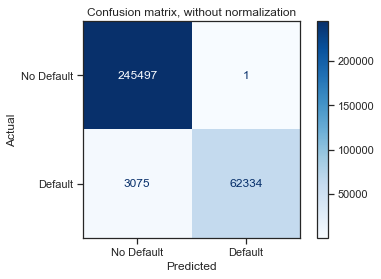

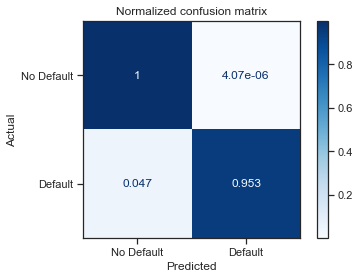

In [18]:
plotConfusionMatrix('No Default', 'Default', model, X_test_data, y_test)

No Skill: ROC AUC=0.500
model : ROC AUC=0.993


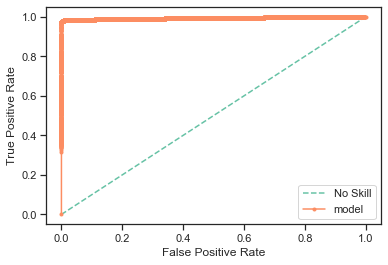

In [19]:
plot_roc_curve_1(model, 'model', X_test_data, y_test)